# Autism Prediction Using Protein Biomarkers

**Link to Project based on: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0246581, and from UCSB Capstone 2024-25**
## Project Overview
This project aims to predict autism diagnosis in children aged 8 months to 10 years using protein biomarker data. We will develop and compare multiple machine learning models to identify the most significant protein markers associated with autism spectrum disorder (ASD).

## Methodology
Our approach combines three feature selection methods to identify crucial protein biomarkers:
1. T-test statistical analysis for most significant proteins
2. Random Forest importance scoring

## Modeling Strategies

### Model 1: Intersection Approach
- Identify key proteins present in all feature selection methods
- Implement a Dense Neural Network with sigmoid activation
- Compare performance against a Generalized Linear Model (GLM)
- Focus on high-confidence protein markers

### Model 2: Union Approach
- Include proteins identified by any of the feature selection methods
- Implement the same Neural Network architecture
- Compare against GLM performance
- Evaluate whether a broader set of protein markers improves prediction accuracy

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras_tuner import Hyperband

In [2]:
# load in cleaned data
biomarker_clean = pd.read_csv('biomarker-clean.csv')
biomarker_clean.head()

,group,Target,CHIP,CEBPB,NSE,PIAS4,IL-10 Ra,STAT3,IRF1,c-Jun,...,Transgelin-2,ATPO,Corticotropin-lipotropin,QORL1,PEDF,CATF,FTCD,UBP25,PLXB2,ados
0,ASD,NaN,0.335009,0.520303,-0.554298,0.649609,-0.357510,0.305328,-0.484193,0.308533,...,-0.258694,0.458736,1.133789,0.858608,-0.331575,-1.795728,3.000000,-0.477235,-1.234194,8.0
1,ASD,NaN,-0.071454,1.006274,3.000000,1.278818,-0.132677,1.133698,0.253024,0.407903,...,0.142860,-0.022246,-0.612397,-1.184603,-0.467821,-1.286492,0.783710,0.138254,0.095212,21.0
2,ASD,NaN,-0.406015,-0.531037,-0.059221,1.129386,0.553756,-0.333915,0.286523,-0.844532,...,-0.474468,-0.581352,-0.692143,0.272451,-1.340909,1.593076,-1.145940,-0.689551,0.838586,12.0
3,ASD,NaN,-0.101941,-0.250912,1.473261,0.077316,-0.704625,0.892828,2.607385,-0.372294,...,-0.140282,-0.740797,2.135767,-0.277749,0.149180,0.039046,-0.096161,-0.353567,-0.900581,20.0
4,ASD,NaN,-0.395238,-0.536000,0.041022,-0.298900,-0.830069,0.898742,1.014317,-0.843280,...,0.124020,-0.662626,-0.210703,-0.780781,0.187370,-0.407526,0.237886,-0.522804,0.504190,22.0


## T-Test Protein Importance Approach

In [3]:
# Applying T-Test
# data has already been log scaled, centered, and trimmed

# select ASD and TD groups and protein names
ASD_group = biomarker_clean[biomarker_clean['group'] == 'ASD']
TD_group = biomarker_clean[biomarker_clean['group'] == 'TD']
protein_names = biomarker_clean.columns[2:-1]

# perform t-test
t_stat, p_values = ttest_ind(ASD_group[protein_names], TD_group[protein_names], axis=0, equal_var=False)

# identify top 15 proteins
top_protein_indices = np.argsort(p_values)[:15]
ttest_proteins = protein_names[top_protein_indices]
ttest_proteins = list(ttest_proteins)
print(ttest_proteins)

['DERM', 'RELT', 'FSTL1', 'C1QR1', 'Calcineurin', 'CXCL16, soluble', 'IgD', 'MRC2', 'PTN', 'Cadherin-5', 'MAPK2', 'TGF-b R III', 'DAF', 'MIA', 'Notch 1']


## Random Forest Protein Importance Approach

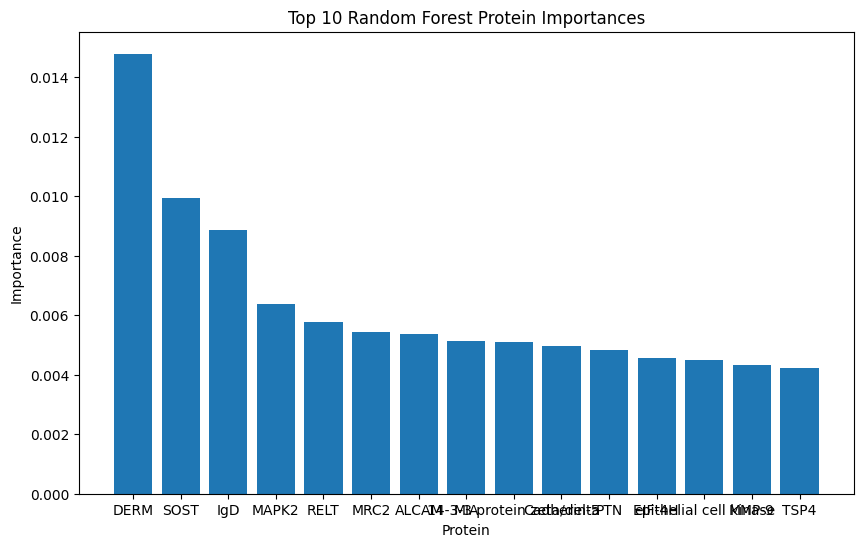

['DERM', 'SOST', 'IgD', 'MAPK2', 'RELT', 'MRC2', 'ALCAM', 'MIA', '14-3-3 protein zeta/delta', 'Cadherin-5', 'PTN', 'eIF-4H', 'Epithelial cell kinase', 'MMP-9', 'TSP4']


In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt

# change group to binary 0/1
le = LabelEncoder()

protein_names = biomarker_clean.columns[2:-1] 
# change into numpy arrays
train_data, test_data, train_labels, test_labels = train_test_split(biomarker_clean[protein_names].to_numpy(),
                                                                    le.fit_transform(biomarker_clean['group'].to_numpy()), # encode group ASD/TD to 0/1
                                                                    test_size=0.2,
                                                                    random_state=42)


# training a random forest model
rf = RandomForestClassifier(n_estimators=1000,
                            max_depth = 10,
                            random_state=42)
rf.fit(train_data, train_labels)

# check errors through confusion matrix
confusion_matrix(test_labels, rf.predict(test_data))

# importances for top 10 proteins
rf_proteins = pd.Series(rf.feature_importances_, index=protein_names) # convert to pandas series
rf_proteins = rf_proteins.sort_values(ascending=False)[:15] # top 15 proteins sorted by importance

# plot importances
plt.figure(figsize=(10, 6))
plt.bar(rf_proteins.index, rf_proteins.values)
plt.title('Top 10 Random Forest Protein Importances')
plt.xlabel('Protein')
plt.ylabel('Importance')
plt.show()

# change to list
rf_proteins = list(rf_proteins.index)
print(rf_proteins)

## Intersection and Union of Top 15 Protein Predictions
- In this block of code, we will perform the union and intersection of the top 10 most important proteins from each machine learning model and the T-Test Stats.

In [5]:
# intersection
protein_intersection = list(set(ttest_proteins) & set(rf_proteins))
print(protein_intersection)

# union
protein_union = list(set(ttest_proteins) | set(rf_proteins))
print(protein_union)

['PTN', 'MAPK2', 'IgD', 'MIA', 'DERM', 'RELT', 'Cadherin-5', 'MRC2']
['FSTL1', 'MAPK2', 'TSP4', 'CXCL16, soluble', 'Epithelial cell kinase', 'SOST', 'Calcineurin', 'PTN', 'eIF-4H', 'IgD', '14-3-3 protein zeta/delta', 'MIA', 'MMP-9', 'DERM', 'C1QR1', 'TGF-b R III', 'RELT', 'Cadherin-5', 'MRC2', 'Notch 1', 'DAF', 'ALCAM']


## TensorFlow Keras Compared to GLM Model for Group Prediction

In [6]:
# GLM model to compare against the TensorFlow Keras model
intersection_data = biomarker_clean[['group'] + protein_intersection]
intersect_train_data, intersect_test_data, intersect_train_labels, intersect_test_labels = train_test_split(intersection_data[protein_intersection], # features
                                                                                                            le.fit_transform(intersection_data['group']), # target
                                                                                                            test_size=0.2,
                                                                                                            random_state=42)
intersect_train_small, intersect_val_data, intersect_train_labels_small, intersect_val_labels = train_test_split(intersect_train_data,
                                                                                                            intersect_train_labels,
                                                                                                            test_size=0.25,
                                                                                                            random_state=42)

## Intersection DNN Approach

In [7]:
# build the keras model using hyperband mdoel
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value = 256, step=16), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.1, max_value=0.5, default=0.25)))
    model.add(Dense(units=hp.Int('units', min_value=32, max_value = 256, step=16), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.1, max_value=0.5, default=0.25)))
    model.add(Dense(1, activation='sigmoid'))
    # compile the model
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.0001, 0.001, 0.01, 0.1])),
                  loss='binary_crossentropy',
                  metrics=['accuracy', 'AUC'])
    return model

Reloading Tuner from Neural_net_Model_Perf/intersection_NN_model/tuner0.json
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - AUC: 0.5645 - accuracy: 0.5636 - loss: 3.3010 - val_AUC: 0.8445 - val_accuracy: 0.7742 - val_loss: 1.6675
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.6531 - accuracy: 0.6242 - loss: 3.3687 - val_AUC: 0.8929 - val_accuracy: 0.8710 - val_loss: 1.7328
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7976 - accuracy: 0.7764 - loss: 2.1951 - val_AUC: 0.8613 - val_accuracy: 0.6774 - val_loss: 2.1181
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7982 - accuracy: 0.6704 - loss: 2.2489 - val_AUC: 0.9328 - val_accuracy: 0.8710 - val_loss: 0.8856
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8716 - accuracy: 0.8044 - loss: 1.0884 - val_AUC: 0.9370 - val_accuracy: 0.9032 - val_loss: 0.3297
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8309 - accuracy: 0.7199 - loss: 0.9170 - val_AUC: 0.9622 - val_accuracy: 0.9355 - val

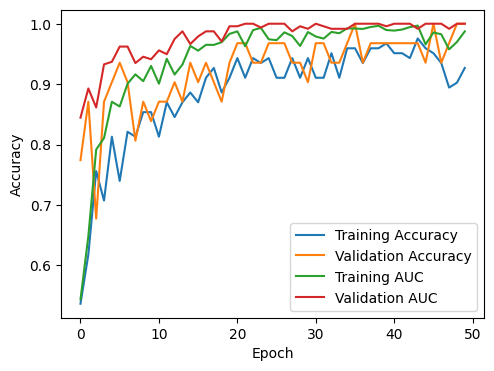

In [8]:
# build a model with cross validation
tuner = Hyperband(build_model,
                  objective='val_accuracy',
                  max_epochs=50,
                  factor=3,
                  directory='Neural_net_Model_Perf',
                  project_name='intersection_NN_model')

# search for best hp
tuner.search(intersect_train_small, intersect_train_labels_small,
             epochs=50,
             validation_data=(intersect_val_data, intersect_val_labels),
             callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)

# build best model
best_model = tuner.hypermodel.build(best_hps)

# retrain the best model on whole training set
history = best_model.fit(intersect_train_data, intersect_train_labels,
               epochs=50,
               validation_data=(intersect_val_data, intersect_val_labels),
               callbacks=[EarlyStopping(monitor='val_loss', patience=10)])

# plot the training accuracy and auc scores
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['AUC'], label='Training AUC')
plt.plot(history.history['val_AUC'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
# Convert predictions back to original labels
predictions = best_model.predict(intersect_test_data)
binary_predictions = (predictions > 0.5).astype(int)
original_predictions = le.inverse_transform(binary_predictions)
original_test_labels = le.inverse_transform(intersect_test_labels)

# Print confusion matrix with original labels
print("Intersection Confusion Matrix:")
print(confusion_matrix(original_test_labels, original_predictions))

# Print classification report with original labels
print("\n Intersection Classification Report:")
print(classification_report(original_test_labels, original_predictions))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Intersection Confusion Matrix:
[[10  5]
 [ 2 14]]

 Intersection Classification Report:
              precision    recall  f1-score   support

         ASD       0.83      0.67      0.74        15
          TD       0.74      0.88      0.80        16

    accuracy                           0.77        31
   macro avg       0.79      0.77      0.77        31
weighted avg       0.78      0.77      0.77        31



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
# fit a GLM model for comparison
GLM = LogisticRegression(penalty='l1', solver='liblinear')
GLM.fit(intersect_train_data, intersect_train_labels)

# check errors through confusion matrix
print("Intersection Confusion Matrix:")
print(confusion_matrix(intersect_test_labels, GLM.predict(intersect_test_data)))
print("Intersection Classification Report:")
print(classification_report(le.inverse_transform(intersect_test_labels), le.inverse_transform(GLM.predict(intersect_test_data))))


Intersection Confusion Matrix:
[[ 9  6]
 [ 3 13]]
Intersection Classification Report:
              precision    recall  f1-score   support

         ASD       0.75      0.60      0.67        15
          TD       0.68      0.81      0.74        16

    accuracy                           0.71        31
   macro avg       0.72      0.71      0.70        31
weighted avg       0.72      0.71      0.71        31



## Union Neural Network Versus GLM

In [11]:
# union DNN approach
union_data = biomarker_clean[['group'] + protein_union]
union_train_data, union_test_data, union_train_labels, union_test_labels = train_test_split(union_data[protein_union],
                                                                                            le.fit_transform(union_data['group']),
                                                                                            test_size=0.2,
                                                                                            random_state=42)
# validation set
union_train_small, union_val_data, union_train_labels_small, union_val_labels = train_test_split(union_train_data,
                                                                                            union_train_labels,
                                                                                            test_size=0.25,
                                                                                            random_state=42)

Reloading Tuner from Neural_net_Model_Perf/union_NN_model/tuner0.json
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - AUC: 0.5570 - accuracy: 0.5313 - loss: 0.7053 - val_AUC: 0.9412 - val_accuracy: 0.8710 - val_loss: 0.3103
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.8699 - accuracy: 0.7622 - loss: 0.4635 - val_AUC: 0.9664 - val_accuracy: 0.8710 - val_loss: 0.2366
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8980 - accuracy: 0.8157 - loss: 0.4079 - val_AUC: 0.9664 - val_accuracy: 0.9032 - val_loss: 0.2174
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.8999 - accuracy: 0.8506 - loss: 0.4278 - val_AUC: 0.9790 - val_accuracy: 0.9355 - val_loss: 0.1976
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9406 - accuracy: 0.8628 - loss: 0.3212 - val_AUC: 0.9790 - val_accuracy: 0.9355 - val_loss: 0.1950
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - AUC: 0.9286 - accuracy: 0.8540 - loss: 0.3388 - val_AUC: 0.9748 - val_accuracy: 0.9355 - val_loss: 

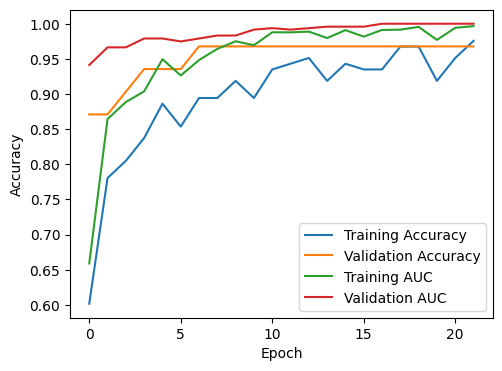

In [12]:
union_tuner = Hyperband(build_model,
                        objective='val_accuracy',
                        max_epochs=50,
                        factor=3,
                        directory='Neural_net_Model_Perf',
                        project_name='union_NN_model')

# search for best hp
union_tuner.search(union_train_small, union_train_labels_small,
             epochs=50,
             validation_data=(union_val_data, union_val_labels),
             callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# get best hp
best_union_hps = union_tuner.get_best_hyperparameters(num_trials=1)[0]

# build best model, and train on whole training set
best_union_model = union_tuner.hypermodel.build(best_union_hps)
history_union = best_union_model.fit(union_train_data, union_train_labels,
                                     epochs = 50,
                                     validation_data=(union_val_data, union_val_labels),
                                     callbacks=[EarlyStopping(monitor='val_loss', patience=4)])

# plot the training accuracy and auc scores
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_union.history['accuracy'], label='Training Accuracy')
plt.plot(history_union.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_union.history['AUC'], label='Training AUC')
plt.plot(history_union.history['val_AUC'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
# predicting on the test set with final model
predictions_union = best_union_model.predict(union_test_data)
binary_predictions_union = (predictions_union > 0.5).astype(int)
original_predictions_union = le.inverse_transform(binary_predictions_union)
original_test_labels_union = le.inverse_transform(union_test_labels)
# print confusion matrix and classification report
print("Union Confusion Matrix:")
print(confusion_matrix(original_test_labels_union, original_predictions_union))
print("Union Classification Report:")
print(classification_report(original_test_labels_union, original_predictions_union))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Union Confusion Matrix:
[[13  2]
 [ 7  9]]
Union Classification Report:
              precision    recall  f1-score   support

         ASD       0.65      0.87      0.74        15
          TD       0.82      0.56      0.67        16

    accuracy                           0.71        31
   macro avg       0.73      0.71      0.70        31
weighted avg       0.74      0.71      0.70        31



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
# fit a GLM Model for comparison
GLM_union = LogisticRegression(penalty='l1', solver='liblinear')
GLM_union.fit(union_train_small, union_train_labels_small)

# check errors through confusion matrix
print(confusion_matrix(union_test_labels, GLM_union.predict(union_test_data)))
print(classification_report(le.inverse_transform(union_test_labels), le.inverse_transform(GLM_union.predict(union_test_data))))

[[11  4]
 [ 7  9]]
              precision    recall  f1-score   support

         ASD       0.61      0.73      0.67        15
          TD       0.69      0.56      0.62        16

    accuracy                           0.65        31
   macro avg       0.65      0.65      0.64        31
weighted avg       0.65      0.65      0.64        31



# Neural Network Using all Predictors

In [15]:
# using all proteins to predict group
predictors = biomarker_clean.columns[2:-1].to_numpy()
all_protein_train_data, all_protein_test_data, all_protein_train_labels, all_protein_test_labels = train_test_split(biomarker_clean[predictors],
                                                                                                            le.fit_transform(biomarker_clean['group'].to_numpy()),
                                                                                                            test_size=0.2,
                                                                                                            random_state=42)
# create a validation set
all_protein_train_small, all_protein_val_data, all_protein_train_labels_small, all_protein_val_labels = train_test_split(all_protein_train_data,
                                                                                                            all_protein_train_labels,
                                                                                                            test_size=0.25,
                                                                                                            random_state=42)

Reloading Tuner from Neural_net_Model_Perf/all_protein_NN_model/tuner0.json
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - AUC: 0.3517 - accuracy: 0.3560 - loss: 0.8809 - val_AUC: 0.4685 - val_accuracy: 0.5161 - val_loss: 0.7552
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.5527 - accuracy: 0.4894 - loss: 0.7180 - val_AUC: 0.6786 - val_accuracy: 0.6452 - val_loss: 0.6394
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7176 - accuracy: 0.6429 - loss: 0.6152 - val_AUC: 0.7941 - val_accuracy: 0.7419 - val_loss: 0.5561
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7357 - accuracy: 0.6694 - loss: 0.6033 - val_AUC: 0.8571 - val_accuracy: 0.8065 - val_loss: 0.4993
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7526 - accuracy: 0.6616 - loss: 0.5930 - val_AUC: 0.8824 - val_accuracy: 0.8065 - val_loss: 0.4554
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7952 - accuracy: 0.7095 - loss: 0.5416 - val_AUC: 0.9181 - val_accuracy: 0.8065 - val_

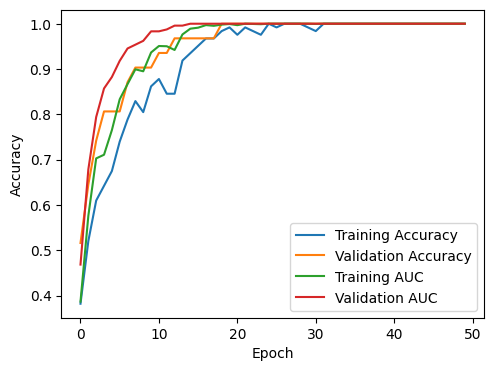

In [16]:
# Create a tuner object
all_protein_tuner = Hyperband(build_model,
                        objective='val_accuracy',
                        max_epochs=50,
                        factor=3,
                        directory='Neural_net_Model_Perf',
                        project_name='all_protein_NN_model')
# search for best hp
all_protein_tuner.search(all_protein_train_small, all_protein_train_labels_small,
                         epochs=50,
                         validation_data=(all_protein_val_data, all_protein_val_labels),
                         callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# get the best hp
best_all_protein_hps = all_protein_tuner.get_best_hyperparameters(num_trials=1)[0]

# build best model, and train on whole training set
best_all_protein_model = all_protein_tuner.hypermodel.build(best_all_protein_hps)
history_all_protein = best_all_protein_model.fit(all_protein_train_data, all_protein_train_labels,
                                                 epochs=50,
                                                 validation_data=(all_protein_val_data, all_protein_val_labels),
                                                 callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

# plot the training accuracy and auc scores
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_all_protein.history['accuracy'], label='Training Accuracy')
plt.plot(history_all_protein.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_all_protein.history['AUC'], label='Training AUC')
plt.plot(history_all_protein.history['val_AUC'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## All Protein Neural Network Predictions

In [17]:
# predicting on the test set with final model
predictions_all_protein = best_all_protein_model.predict(all_protein_test_data)
binary_predictions_all_protein = (predictions_all_protein > 0.5).astype(int) # convert if above 0.5, then 1, else 0 since binary classification
# convert back to original labels
original_predictions_all_protein = le.inverse_transform(binary_predictions_all_protein)
original_test_labels_all_protein = le.inverse_transform(all_protein_test_labels)

# print confusion matrix and classification report
print(confusion_matrix(original_test_labels_all_protein, original_predictions_all_protein, labels=['ASD', 'TD']))
print(classification_report(original_test_labels_all_protein, original_predictions_all_protein, labels=['ASD', 'TD']))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[11  4]
 [ 5 11]]
              precision    recall  f1-score   support

         ASD       0.69      0.73      0.71        15
          TD       0.73      0.69      0.71        16

    accuracy                           0.71        31
   macro avg       0.71      0.71      0.71        31
weighted avg       0.71      0.71      0.71        31



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Conclusion and Results

After using T-Test to find the most statistically significant proteins, a Random Forest on all proteins to obtain the most influential and important proteins, we created two different sets of proteins. One of the sets included an intersection between the T-Test and the random forest, and one included a union between the two predicting methods. Furthermore, I added in a model including all proteins to see if this gives an opportunity to determine if including more proteins implies a better performing model.

Key findings from our analysis:

1. **Intersection Method**:
   - Neural Network performance was 77% accuracy
   - GLM achieved slightly worse results with 71% accuracy
   - Suggests that using fewer proteins as a panel will improve model performance.

2. **Union Method**:
   - Neural Network achieved 71% accuracy
   - GLM performance dropped to 65% accuracy
   - Indicates that neural networks may handle larger feature sets more effectively

3. **All Proteins Model**:
   - Neural Network maintained consistent performance to unionized set of proteins
   - Demonstrates that careful feature selection is important, as using all proteins didn't improve results
   - There may be potential overfitting when using the complete protein set

Implications:
- Feature selection methods are crucial for model performance
- Simpler models such as a GLM model still performs well with a neural network.
- Neural Networks show more resilience to larger feature sets
- 71% seems to be reoccuring when using more proteins, indicating that more proteins may not enhance the model performance.

Future Directions:
- Investigate alternative feature selection methods such as correlational values.
- Explore ensemble methods combining multiple models
- Consider collecting additional biomarker data or patient metadata
- Consider using different Neural Network types such as convolution or Reccurent or maybe simpler models.
- Test model performance on external validation datasets
- Consider using Xgboost as another importance Predictor